# dPb concentrations across the domain for a single depth level

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import pandas as pd
import xarray as xr

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

# model results:
year = 2002
results_folder1 = f'/data/brogalla/run_storage/Pb-tuning-202302/Pb-tuning-202302-2002-method5-fsb-b010-p015-allon/'

#### Load files:

In [3]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
ANHA12_lon   = mfile['nav_lon'].values
ANHA12_lat   = mfile['nav_lat'].values
tmask        = mfile['tmask'].values
tmask_sub    = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]

mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_bathy   = mesh['hdept'].values[0]
e3t          = mesh['e3t_0'].values[0,:,imin:imax,jmin:jmax]
land_mask    = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
e3t_masked   = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), e3t)

In [4]:
month  = 1
results     = xr.open_dataset(f'{results_folder1}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc')
lons_model  = results['nav_lon'].values
lats_model  = results['nav_lat'].values
depth_model = results['deptht'].values
dissolpb    = results['dissolpb'].values[0,:,:,:]*1e12 # pM units

#### Functions:

In [9]:
def plot_layer(plot_variable, vmin=0,vmax=35, savefig=False):
    cmap1 = cmocean.cm.matter
    cmap1.set_bad('#d4d4d3', 1)
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb-map.pickle','rb'))

    x, y = proj1(lons_model, lats_model)
    
    pcolor  = proj1.pcolormesh(x, y, plot_variable, cmap=cmap1, vmin=vmin, vmax=vmax)
    contour = proj1.contourf(np.zeros_like(x), np.zeros_like(y), np.zeros_like(plot_variable), np.arange(vmin,vmax+1,1),\
                             cmap=cmap1, vmin=vmin, vmax=vmax, extend='both')

    cbar_ax = fig.add_axes([0.15, 0.15, 0.04, 0.35])
    cbar    = fig.colorbar(contour, cax=cbar_ax)
    cbar.set_label('Dissolved Pb [pM]', fontsize=6) 
    cbar_ax.tick_params(axis='both', which='major', labelsize=6)
      
    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/R3-field-August.jpg', \
                       bbox_inches='tight', dpi=300)
    
    return

In [10]:
def calculate_depth_weighted(dPb, levels=(0,16)):
    
    dPb_weighted     = dPb[levels[0]:levels[1],:,:]*e3t[levels[0]:levels[1],:,:]
    
    # bottom depth (in case of regions shallower than levels[1]: 
    depth_top        = np.zeros_like(mesh_bathy[imin:imax,jmin:jmax])
    if levels[0] != 0:
        depth_top[mesh_bathy[imin:imax,jmin:jmax] > depth_model[levels[0]-1]] = depth_model[levels[0]-1] # top of layer is not the surface
    depth_bottom     = np.copy(mesh_bathy[imin:imax,jmin:jmax])
    depth_bottom[depth_bottom > depth_model[levels[1]-1]] = depth_model[levels[1]-1]
    delta_depth      =  depth_bottom - depth_top
                 
    # calculate average:
    dPb_weighted_ave = np.sum(dPb_weighted, axis=0) / delta_depth
    
    return dPb_weighted_ave

#### Figures of surface concentrations:

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


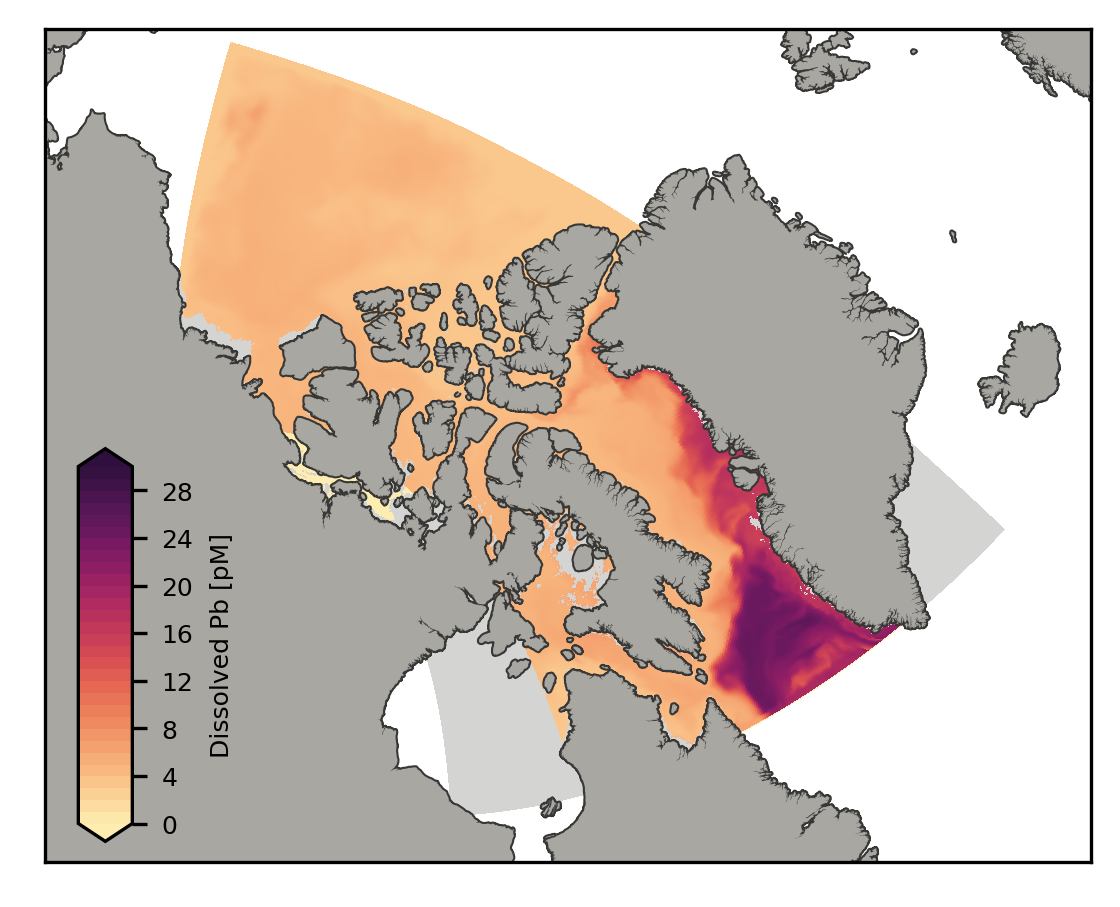

In [12]:
plot_variable = calculate_depth_weighted(dissolpb, levels=(3,16))

var_masked    = np.ma.masked_where(tmask_sub[16,:,:] < 0.1, plot_variable)
plot_layer(var_masked, vmin=0, vmax=30, savefig=False)